In [35]:
# --- IMPORTS ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [ ]:
# --- CONFIGURABLE PARAMETERS ---
# Domain boundaries
x_min, x_max = 0.0, 1.0  # x-coordinate bounds
y_min, y_max = 0.0, 1.0  # y-coordinate bounds

# Neural network architecture and training parameters
layers = [2, 30, 30, 30, 30, 1]  # Network architecture: [input_dim, hidden_dim, output_dim]
lr_initial = 0.01    # Initial learning rate for Adam optimizer
epochs = 5000       # Number of training epochs
alpha = 10
beta = 10          # Weight for boundary condition loss term
eps_initial = 2

# Sampling parameters
N_interior = 10000    # Number of interior training points
N_boundary = 800     # Number of boundary training points
N_test = 2500     # Number of boundary test points
N_sensor = 1000

In [37]:
def set_device():
    """
    Configure and select the computational device (GPU/CPU).
    
    Returns:
        str: Device identifier ('/GPU:0' or '/CPU:0')
    """
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("Using GPU")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        return '/GPU:0'
    print("Using CPU")
    return '/CPU:0'

In [38]:
device = set_device()  

Using GPU


In [39]:
def generate_boundary_points(xmin, xmax, ymin, ymax, num_points):
    """
    Generate training points along the domain boundaries.
    
    Args:
        xmin, xmax (float): x-coordinate bounds
        ymin, ymax (float): y-coordinate bounds
        num_points (int): Total number of boundary points to generate
    
    Returns:
        tuple: Arrays of x and y coordinates for boundary points
    """
    num_per_edge = num_points // 4
    # Generate points for each boundary edge
    bottom = np.column_stack((np.linspace(x_min, x_max, num_per_edge), np.full((num_per_edge,), y_min)))
    right = np.column_stack((np.full((num_per_edge,), x_max), np.linspace(y_min, y_max, num_per_edge)))
    top = np.column_stack((np.linspace(x_min, x_max, num_per_edge), np.full((num_per_edge,), y_max)))
    left = np.column_stack((np.full((num_per_edge,), x_min), np.linspace(y_min, y_max, num_per_edge)))
    boundary_pt = np.row_stack((bottom, right, top, left))
    return boundary_pt

In [40]:
def generate_interior_points(xmin, xmax, ymin, ymax, num_points):
    """
    Generate training points along the domain boundaries.
    
    Args:
        xmin, xmax (float): x-coordinate bounds
        ymin, ymax (float): y-coordinate bounds
        num_points (int): Total number of boundary points to generate
    
    Returns:
        tuple: Arrays of x and y coordinates for boundary points
    """
    x_train_interior = np.random.uniform(x_min, x_max, (N_interior, 1))
    y_train_interior = np.random.uniform(y_min, y_max, (N_interior, 1))
    interior_pt = np.column_stack((x_train_interior, y_train_interior))
    return interior_pt

In [41]:
def generate_test_points(xmin, xmax, ymin, ymax, num_points):
    num = int(np.sqrt(num_points))
    x_test = np.linspace(xmin, xmax, num)
    y_test = np.linspace(ymin, ymax, num)
    X_test, Y_test = np.meshgrid(x_test, y_test)
    test_pt = np.column_stack((X_test.flatten(), Y_test.flatten()))
    return test_pt

In [42]:
def generate_sensor_points(xmin, xmax, ymin, ymax, num_sensor):
    x_sensor = np.random.uniform(xmin, xmax, num_sensor)
    y_sensor = np.random.uniform(ymin, ymax, num_sensor)
    sensor_pt = np.column_stack((x_sensor, y_sensor))
    return sensor_pt

In [43]:
def analytical_solution_inverse(points, eps = 0.3):
    """
    Analytical solution for the inverse problem using TensorFlow functions.
    Args:
        x, y: spatial coordinates in [0,1]²
        epsilon: diffusion coefficient
    Returns:
        u: exact solution
    """
    x = tf.expand_dims(points[:,0], axis = 1)
    val = tf.sin(x) * tf.tanh(x) * tf.exp(-1.0 * eps * (x**2)) * 10
    return val

In [44]:
def u_bc(points, eps = 0.3):
    """
    Define the Dirichlet boundary condition.
    
    Args:
        x (tf.Tensor): (x,y)-coordinates of boundary points
    
    Returns:
        tf.Tensor: Boundary values (zero in this case)
    """
    val = analytical_solution_inverse(points, eps)
    return val

In [45]:
def generate_sensor_data(points, eps = 0.3):
    """Generate random sensor locations and measurements"""
    measurements = analytical_solution_inverse(points, eps)
    return measurements

In [46]:
# @tf.function
def f(points, eps):
    """
    Define the forcing function for the PDE.
    
    Args:
        x (tf.Tensor): x-coordinates
        y (tf.Tensor): y-coordinates
    
    Returns:
        tf.Tensor: Values of the forcing function at given points
    """
    x = tf.expand_dims(points[:,0], axis = 1)
    val = -eps* (
            40.0 * x * eps * (tf.tanh(x) ** 2 - 1) * tf.sin(x)
            - 40.0 * x * eps * tf.cos(x) * tf.tanh(x)
            + 10 * eps * (4.0 * x**2 * eps - 2.0) * tf.sin(x) * tf.tanh(x)
            + 20 * (tf.tanh(x) ** 2 - 1) * tf.sin(x) * tf.tanh(x)
            - 20 * (tf.tanh(x) ** 2 - 1) * tf.cos(x)
            - 10 * tf.sin(x) * tf.tanh(x)
        )* tf.exp(-1.0 * x**2 * eps)
    return val

In [47]:
# @tf.function
def pde_loss_fn(model, train_interior, eps):
    """
    Calculate the PDE residual loss using automatic differentiation.
    
    Args:
        model (tf.keras.Model): Neural network model
        train_interior (tf.Tensor): Interior training points
        eps (float): Diffusion coefficient
    
    Returns:
        tf.Tensor: Mean squared PDE residual
    """
    
    # Calculate derivatives using automatic differentiation
    x = tf.expand_dims(train_interior[:,0], axis = 1)
    y = tf.expand_dims(train_interior[:,1], axis = 1)
    with tf.GradientTape(persistent= True) as tape1:
        tape1.watch(x)
        tape1.watch(y)
        with tf.GradientTape(persistent = True) as tape2:
            tape2.watch(x)
            tape2.watch(y)  
            u = model(tf.concat([x,y], axis = 1))
        grad_x = tape2.gradient(u, x)
        grad_y = tape2.gradient(u, y)
    grad_xx = tape1.gradient(grad_x, x)
    grad_yy = tape1.gradient(grad_y, y)
    del tape1
    del tape2
    residual = -eps*(grad_xx + grad_yy) - f(train_interior, eps)
    return tf.reduce_mean(tf.square(residual))

In [48]:
# @tf.function
def bc_loss_fn(model, x_bd):
    """
    Calculate the boundary condition loss.
    
    Args:
        model (tf.keras.Model): Neural network model
        x_bd (tf.Tensor): Boundary points
    
    Returns:
        tf.Tensor: Mean squared error at boundary points
    """
    u_pred = model(x_bd)
    u_exact = u_bc(x_bd)
    return tf.reduce_mean(tf.square(u_pred - u_exact))

In [49]:
# @tf.function
def sensor_loss_fn(model, x_sensor):
    """
    Calculate the boundary condition loss.
    
    Args:
        model (tf.keras.Model): Neural network model
        x_sensor (tf.Tensor): Boundary points
    
    Returns:
        tf.Tensor: Mean squared error at boundary points
    """
    u_pred = model(x_sensor)
    u_exact = generate_sensor_data(x_sensor)
    return tf.reduce_mean(tf.square(u_pred - u_exact))

In [50]:
# @tf.function
def train_step(model, optimizer, train_interior, train_boundary, train_sensor, eps, alpha, beta):
    """
    Train the PINN model.
    
    Args:
        model (tf.keras.Model): Neural network model
        epochs (int): Number of training epochs
        train_interior (tf.Tensor): Interior training points
        train_boundary (tf.Tensor): Boundary training points
        eps (float): Diffusion coefficient
        beta (float): Weight for boundary condition loss
    """
    
        # Compute gradients and update model parameters
    with tf.GradientTape() as tape:
        loss_pde = pde_loss_fn(model, train_interior, eps)
        loss_bc = beta * bc_loss_fn(model, train_boundary)
        loss_sensor = alpha * sensor_loss_fn(model, train_sensor)
        total_loss = loss_pde + loss_sensor + loss_bc 
        
    grads = tape.gradient(total_loss, model.trainable_variables+[eps])
    optimizer.apply_gradients(zip(grads, model.trainable_variables+[eps]))
    return total_loss, loss_pde, loss_bc, loss_sensor, eps
            

In [51]:
# --- MAIN EXECUTION ---
train_interior = generate_interior_points(x_min, x_max, y_min, y_max, N_interior)
train_interior = tf.convert_to_tensor(train_interior, dtype = tf.float32)

train_boundary = generate_boundary_points(x_min, x_max, y_min, y_max, N_boundary)
train_boundary = tf.convert_to_tensor(train_boundary, dtype = tf.float32)

train_sensor = generate_sensor_points(x_min, x_max, y_min, y_max, N_sensor)
train_sensor = tf.convert_to_tensor(train_sensor, dtype = tf.float32)

total_loss_ar = []
pde_loss_ar = []
bound_loss_ar = []
sensor_loss_ar = []
eps_ar = []

# Create and train model on specified device
with tf.device(device):
    # Define neural network architecture
    eps = tf.Variable(initial_value=eps_initial, trainable=True, dtype=tf.float32)
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        *[tf.keras.layers.Dense(units, activation='tanh') for units in layers[1:-1]],
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.optimizers.Adam(learning_rate=lr_initial)
    # Train the model
    for epoch in range(epochs):  # Use tf.range for compatibility with tf.function
        total_loss, pde_loss, bound_loss, sensor_loss, eps = train_step(model, optimizer, train_interior, train_boundary, train_sensor,
                                                                         eps, alpha, beta)
        total_loss_ar.append(total_loss.numpy())
        pde_loss_ar.append(pde_loss.numpy())
        bound_loss_ar.append(bound_loss.numpy())
        sensor_loss_ar.append(sensor_loss.numpy())
        eps_ar.append(eps.numpy())
        # Print training progress inside the tf.function
        if epoch % 500 == 0 or epoch == epochs - 1:
            # Use tf.print to correctly print the values inside tf.function
            print("Epoch:", epoch, 
                    "Total Loss:", total_loss.numpy(), 
                    "PDE Loss:", pde_loss.numpy(), 
                    "BC Loss:", bound_loss.numpy(),
                    "Sensor Loss:", sensor_loss.numpy(),
                    "eps:", eps.numpy())


Epoch: 0 Total Loss: 340.5797 PDE Loss: 156.84343 BC Loss: 103.19866 Sensor Loss: 80.537605 eps: 0.9899998
Epoch: 500 Total Loss: 0.17591837 PDE Loss: 0.021853544 BC Loss: 0.05784803 Sensor Loss: 0.096216805 eps: 0.545192


KeyboardInterrupt: 

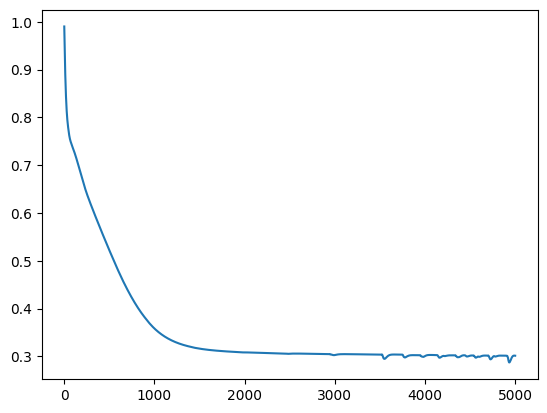

In [ ]:
plt.plot(eps_ar)